# **Building an AUD OIS Yield Curve**
By Vincent Sin | Version 1.0, *2024-07*


---

*The presentation here is just for demonstrating basics concepts for interest rate curve stripping. The model below is under simplied assumption compared to the actual models implemented in the industry.* <span style='color: transparent; font-size:1%'>By Vincent Sin </span>

## **1. Assumptions**

The interest rate index in concern is AUD OIS: **Australian Overnight Index Average (AONIA)**.

For a easy demonstration, we have made some simple assumptions:
- We assume the main liquidity for AUD OIS IRS is with AUD collateral. Moreover, we assume this AUD collateral is remunerated by AUD OIS rate.
  - That is to say the floating rate here is same as the discount rate for AUD OIS IRS.
- The zero coupon rate (yield) is daily compounded, instead of continuously compounded
- Day count as ACT/365. We don't handle in details for years with 366 days for now.
- 0 day start lag and 0 day pay lag
  - The actual convention should be 1 day start lag and 2 days pay lag
- No holidays, not even Saturday and Sunday
- This code only works for AUD OIS, where the payment frequency of the IRS is 1Y.
- The SwapPV method can only price swap with standard tenor


For an actual generic model, it should be able to handle the different conventions and different nature of interest rate index.

## **2. Source Data**

We use only Deposit Rate and Swap Rate for the stripping, as we assume main liquidity for AUD OIS IRS is with AUD collateral.

For cases like a TWD Taibor index, as the main liquidity is under USD collateral, we will need to consider the FX component in stripping. Here in our AUD example this is not a concern.

As of 2024-06-28, from Reuter source **AUDOIS=ICAP**, we have:

| Type    | Tenor | Mid     |
|---------|-------|---------|
| Deposit | ON    | 0.0433  |
| Swap    | 1M    | 0.04332 |
| Swap    | 2M    | 0.0438  |
| Swap    | 3M    | 0.04406 |
| Swap    | 4M    | 0.04429 |
| Swap    | 5M    | 0.04453 |
| Swap    | 6M    | 0.04469 |
| Swap    | 9M    | 0.04502 |
| Swap    | 1Y    | 0.045   |
| Swap    | 18M   | 0.04393 |
| Swap    | 2Y    | 0.04321 |
| Swap    | 3Y    | 0.04206 |
| Swap    | 4Y    | 0.04146 |
| Swap    | 5Y    | 0.04136 |
| Swap    | 6Y    | 0.04159 |
| Swap    | 7Y    | 0.04191 |
| Swap    | 8Y    | 0.0423  |
| Swap    | 9Y    | 0.04268 |
| Swap    | 10Y   | 0.04301 |
| Swap    | 12Y   | 0.04364 |
| Swap    | 15Y   | 0.04414 |
| Swap    | 20Y   | 0.04394 |
| Swap    | 25Y   | 0.04288 |
| Swap    | 30Y   | 0.04161 |

## **3. Yield Curve Model**

## **3.1. Formulas**

In general, we can find the zero rate once we have the discounter factor and vice versa:
$$ r_{zero}(T_n) = DF(T_n) ^{-\frac{1}{\theta_{T_n}}}-1 $$

$$ DF(T_n) =  (1 + r_{zero}(T_n))^{-\theta_{T_n}} $$


With Desposit Rate quote, we can find the zero rate per below:
$$ DF(T_n) = \left(1+DepositRate*\theta_{T_n}\right) ^ {-1} $$

$$ r_{zero}(T_n) = \left(1+DepositRate*\theta_{T_n}\right) ^{\frac{1}{\theta_{T_n}}}-1 $$


For Swap Rate quote, the discount factor will be dependent on previous discount factor. That means we need to find the 1Y discount factor first before we can calculate the 2Y discounter factor. This is what we call **Bootstrapping** interest rate curve stripping.

Please remember that we assume the floating rate here is same as the discount rate for AUD OIS IRS.

Since the Swap quote is at par, the PV of fixed leg = PV of floating leg:

$$ N * \left(\sum_{i=1}^n \theta_{1Y} * F_{T_{i-1}}^{AUD.OIS,1Y} * DF_{AUD.OIS}^{AUD}(T_i) \right) = N * \left(\sum_{i=1}^n \theta_{1Y} * SwapRate * DF_{AUD.OIS}^{AUD}(T_i) \right) $$
where N is notional and F is forward rate.

Since here the discount rate is also AUD.OIS, we can simplify the formula by:

$$ F_{T_{i-1}}^{AUD.OIS,1Y} = \dfrac{1}{\theta_{1Y}}\left(\dfrac{DF_{AUD.OIS}^{AUD}(T_{i-1})}{DF_{AUD.OIS}^{AUD}(T_i)}-1\right) $$

Substitute this and rearrange the formula, we have:

$$DF_{AUD.OIS}^{AUD}(T_n) = \dfrac{1 - \sum_{i=1}^{n-1}\theta_{1Y} * SwapRate * DF_{AUD.OIS}^{AUD}(T_i)}{1 + \theta_{1Y} * SwapRate} $$

which shows the discount factor will depend on the previous ones.

We can express the formula in zero rate:

$$ r_{zero}(T_n) = \left(\dfrac{1+\theta_{1Y}*SwapRate}{1-\sum_{i=1}^{n-1}\theta_{1Y}*SwapRate*DF(T_i)}\right) ^{\frac{1}{\theta_{T_n}}}-1 $$

$$ r_{zero}(T_n) = \displaystyle\left(\dfrac{1+\theta_{1Y} * SwapRate}{1-\sum_{i=1}^{n-1}\theta_{1Y} * SwapRate * [1 + r_{zero}(T_i)]^{-\theta_{T_i}}}\right) ^{\frac{1}{\theta_{T_n}}}-1 $$

## **3.2. Coding logics**

For deposit rate and 1Y swap rate, the quote itself could already give us the zero rate by the formula above.

For other swap rate, we need the previous discounter factors. For example, 2Y needs 1Y, 3Y needs 1Y & 2Y... 

For 18M to 10Y swap rate, all the previous discounter factors could be found by simple bootstrapping. Therefore we just need to follow the formulas.

For 12Y to 30Y, we will need to apply cubic spline interpolation to find the intermediate points. For instance, when we strip the 12Y point, the 11Y point is not yet known but it is required in formula (as we have yearly coupon in the IRS).

Our approach, we first have an initial guess of the 12Y zero rate, and we build a cubic spline (`scipy.interpolate.CubicSpline`)on the existing zero rate (i.e. from ON to 10Y). By this cubic spline, we can find the 11Y zero rate. Then, we set a cost function as the MtM of the 12Y IRS. Since the quote is at par, we should expect a MtM of 0. We use `scipy.optimize.fmin` to find a 12Y zero rate that could give a 0 MtM.

This approach could ensure to achieve:
- A smooth zero coupon rate (yield) curve by cubic spline
- All the input quotes can be priced with 0 MtM with our yield curve




## **3.3. Coding for Yield Curve Model**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import *
from dateutil.relativedelta import *
from scipy import interpolate, optimize

In [6]:
class Yield_Curve:
    def __init__(self, df, date):
        self.sourcedf = df
        self.asofdate = date
        self.stripdf = pd.DataFrame({'Date':[date],'ZeroCouponRate':[0.0],'DateCountFactor':[0.0]})
        self.fulldf = pd.DataFrame({'Date':[date],'ZeroCouponRate':[0.0],'DateCountFactor':[0.0]})
        self.FindEndDate()
        self.CalDateCountFactor()
        
    def FindEndDate(self):
        for i in range(len(self.sourcedf)):
            if self.sourcedf.loc[i, 'Tenor'][-1] == 'M':
                num = int(self.sourcedf.loc[i, 'Tenor'][:-1])
                self.sourcedf.loc[i, 'EndDate'] = self.asofdate + relativedelta(months=num)
            elif self.sourcedf.loc[i, 'Tenor'][-1] == 'Y':
                num = int(self.sourcedf.loc[i, 'Tenor'][:-1])
                self.sourcedf.loc[i, 'EndDate'] = self.asofdate + relativedelta(years=num)
            elif self.sourcedf.loc[i, 'Tenor'] == 'ON':
                self.sourcedf.loc[i, 'EndDate'] = self.asofdate + relativedelta(days=1)

    def CalDateCountFactor(self):
        for i in range(len(self.sourcedf)):
            self.sourcedf.loc[i, 'DateCount'] = (self.sourcedf.loc[i, 'EndDate'] - self.asofdate).days
            self.sourcedf.loc[i, 'DateCountFactor'] = self.sourcedf.loc[i, 'DateCount'] / 365.0
    
    def CalZeroCouponRate(self):
        for i in range(len(self.sourcedf)): 
            Date = self.sourcedf.loc[i, 'EndDate']
            dcf = self.sourcedf.loc[i, 'DateCountFactor']
            quote = self.sourcedf.loc[i,'Mid']
            
            if self.sourcedf['Type'].iloc[i] == 'Deposit':
                ZC = (1 + quote * dcf) ** (1/dcf) - 1
                self.sourcedf.loc[i,'ZeroCouponRate'] = ZC
                newrow = pd.DataFrame({'Date':[Date],'ZeroCouponRate':[ZC],'DateCountFactor':[dcf]})
                self.stripdf = pd.concat([self.stripdf,newrow], ignore_index=True)
                    
            else:        
                if self.sourcedf['Type'].iloc[i] == 'Swap':
                    if self.sourcedf.loc[i, 'DateCount'] <= 365:
                        ZC = (1 + quote * dcf) ** (1/dcf) - 1
                        self.sourcedf.loc[i,'ZeroCouponRate'] = ZC
                        newrow = pd.DataFrame({'Date':[Date],'ZeroCouponRate':[ZC],'DateCountFactor':[dcf]})
                        self.stripdf = pd.concat([self.stripdf,newrow], ignore_index=True)

                    else:
                        CouponDates = []
                        CouponDCFs = []
                        tenor = self.sourcedf.loc[i, 'Tenor']
                        num = int(tenor[:-1])

                        if tenor == '18M':
                            CouponDates.append(self.asofdate + relativedelta(months=6))
                            dc = (CouponDates[-1] - self.asofdate).days
                            CouponDCFs.append(dc / 365.0)

                            CouponDates.append(self.asofdate + relativedelta(months=18))
                            dc = (CouponDates[-1] - self.asofdate).days
                            CouponDCFs.append(dc / 365.0)
                            
                            CpDCF6m = 0.5
                            CpDCF1y = 1.0
                            intraZC = self.sourcedf.loc[self.sourcedf['Tenor']=='6M','ZeroCouponRate'].values[0]
                            ZC = ((1.0 + quote * CpDCF1y)/(1 - CpDCF6m * quote *(1 + intraZC) ** (- CouponDCFs[0]))) ** (1/dcf) - 1
                            self.sourcedf.loc[i,'ZeroCouponRate'] = ZC
                            newrow = pd.DataFrame({'Date':[Date],'ZeroCouponRate':[ZC],'DateCountFactor':[dcf]})
                            self.stripdf = pd.concat([self.stripdf,newrow], ignore_index=True)
                            
                        else:                         
                            for j in range(num):
                                CouponDates.append(self.asofdate + relativedelta(years=j+1))
                                dc = (CouponDates[-1] - self.asofdate).days
                                CouponDCFs.append(dc / 365.0)
                            
                            # check if interpolation is needed for intermediate points
                            NeedInterpolate = False
                            for j in range(len(CouponDCFs)-1):                           
                                if not self.stripdf['Date'].isin([CouponDates[j]]).any():
                                    NeedInterpolate = True
                                    
                            if NeedInterpolate == True:
                                # Use the last zero coupon rate as guess
                                initial_guess = self.stripdf['ZeroCouponRate'].iloc[-1]
                                # Find a ZC that gives 0 mtm of the swap
                                ZC = optimize.fmin(lambda x: self.CostFunction(x, tenor, quote, CouponDates, CouponDCFs, dcf),
                                                   initial_guess, xtol=1e-10, ftol=1e-10)
                                ZC = float(ZC)
                                
                                # Build the cubic spline to find out all intermediate ZC
                                x = pd.concat([pd.Series(self.stripdf['DateCountFactor'][:]), pd.Series([dcf])], ignore_index=True)
                                y = pd.concat([pd.Series(self.stripdf['ZeroCouponRate'][:]), pd.Series([ZC])], ignore_index=True)
                                ZeroCurve = interpolate.CubicSpline(x,y,bc_type=((2,0.0),(2,0.0)))
                                
                                # For those interpolated intermediate ZC, we store them in stripdf
                                for j in range(len(CouponDCFs)-1):
                                    CouponDate = CouponDates[j]
                                    CouponDCF = CouponDCFs[j]
                                    if not self.stripdf['Date'].isin([CouponDate]).any():
                                        intraZC = ZeroCurve(CouponDCF)
                                        newrow = pd.DataFrame({'Date':[CouponDate],'ZeroCouponRate':[intraZC],'DateCountFactor':[CouponDCF]})
                                        self.stripdf = pd.concat([self.stripdf,newrow], ignore_index=True)
                                
                            else:
                                CpSum = 0.0
                                for j in range(len(CouponDCFs)-1):
                                    CouponDate = CouponDates[j]
                                    CouponDCF = CouponDCFs[j]

                                    intraZC = self.stripdf.loc[self.stripdf['Date']==CouponDate,'ZeroCouponRate'].values[0]

                                    CpDCF = 1.0
                                    CpSum += CpDCF * quote * (1 + intraZC) ** (- CouponDCF)

                                CpDCF = 1.0
                                ZC = ((1.0 + quote * CpDCF)/(1 - CpSum)) ** (1/dcf) - 1
                            
                            self.sourcedf.loc[i,'ZeroCouponRate'] = ZC
                            newrow = pd.DataFrame({'Date':[Date],'ZeroCouponRate':[ZC],'DateCountFactor':[dcf]})
                            self.stripdf = pd.concat([self.stripdf,newrow], ignore_index=True)
    
    def CostFunction(self, lastZCguess, tenor, quote, CouponDates, CouponDCFs, dcf):
        floatPV = 0
        fixPV = 0
        notional = 1000000
        num = int(tenor[:-1])
        
        tempdf = self.stripdf.copy()
        x = pd.concat([pd.Series(tempdf['DateCountFactor'][:]), pd.Series([dcf])], ignore_index=True)
        y = pd.concat([pd.Series(tempdf['ZeroCouponRate'][:]), pd.Series([lastZCguess])], ignore_index=True)
        ZeroCurve = interpolate.CubicSpline(x,y,bc_type=((2,0.0),(2,0.0)))
        
        for j in range(len(CouponDCFs)):
            CouponDate = CouponDates[j]
            CouponDCF = CouponDCFs[j]                              

            if not tempdf['Date'].isin([CouponDate]).any():
                intraZC = ZeroCurve(CouponDCF)
                newrow = pd.DataFrame({'Date':[CouponDate],'ZeroCouponRate':[intraZC],'DateCountFactor':[CouponDCF]})
                tempdf = pd.concat([tempdf,newrow], ignore_index=True)
        
        self.CalDiscountFactor(tempdf)
                
        if tenor[-1] == 'Y':
            DF1 = 1.0
            DF2 = 1.0
            for i in range(num):
                CouponDate = CouponDates[i]
                DF1 = DF2
                DF2 = float(tempdf.loc[tempdf['Date']==CouponDate,'DiscountFactor'])
                CpDCF = 1.0
                fwd = (DF1 / DF2 - 1)/CpDCF
                floatPV += notional * fwd * CpDCF * DF2
                fixPV += notional * quote * CpDCF * DF2
            
            return abs(floatPV - fixPV)
        else:
            # We know in this AUD OIS case, only those swaps greater than 10Y need interpolation
            return 0
    
    def CalDiscountFactor(self, df):
        for i in range(len(df)):
            ZC = df.loc[i,'ZeroCouponRate']
            dcf = df.loc[i,'DateCountFactor']
            df.loc[i,'DiscountFactor'] = (1 + ZC) ** (-dcf)
    
    def BootstrapCurve(self):
        self.CalZeroCouponRate()
        self.CalDiscountFactor(self.stripdf)
    
    def PlotZeroCurve(self):
        x = self.stripdf['Date'][1:]
        y = self.stripdf['ZeroCouponRate'][1:]
        ZeroCurve = interpolate.CubicSpline(x,y,bc_type=((2,0.0),(2,0.0)))
        x2 = date_range = pd.date_range(start=x.iloc[0], end=x.iloc[-1], freq='D')
        y2 = ZeroCurve(x2)
        plt.plot(x,y,'o',x2,y2)
    
    def PlotSwapCurve(self):
        x = self.sourcedf['EndDate'][1:]
        y = self.sourcedf['Mid'][1:]
        plt.plot(x,y,'o',x,y)
        
    def SwapPV(self, tenor, quote, notional = 1000000):
        floatPV = 0
        fixPV = 0
        num = int(tenor[:-1])
        if tenor == '18M':
            CouponDate = self.asofdate + relativedelta(months=6)
            dc = (CouponDate - self.asofdate).days
            CouponDCF = dc / 365.0
            DF = float(self.stripdf.loc[self.stripdf['Date']==CouponDate,'DiscountFactor'])
            CpDCF = 0.5
            fwd = (1 / DF - 1)/CpDCF
            floatPV += notional * fwd * CpDCF * DF
            fixPV += notional * quote * CpDCF * DF
            
            CouponDate = self.asofdate + relativedelta(months=18)
            dc = (CouponDate - self.asofdate).days
            CouponDCF = dc / 365.0
            DF2 = float(self.stripdf.loc[self.stripdf['Date']==CouponDate,'DiscountFactor'])
            CpDCF = 1.0
            fwd = (DF / DF2 - 1)/CpDCF
            floatPV += notional * fwd * CpDCF * DF2
            fixPV += notional * quote * CpDCF * DF2
            
            return floatPV - fixPV
        
        elif tenor[-1] == 'M':
            CouponDate = self.asofdate + relativedelta(months=num)
            DF = float(self.stripdf.loc[self.stripdf['Date']==CouponDate,'DiscountFactor'])
            dc = (CouponDate - self.asofdate).days
            CouponDCF = dc / 365.0
            fwd = (1 / DF - 1)/CouponDCF
            floatPV += notional * fwd * CouponDCF * DF
            fixPV += notional * quote * CouponDCF * DF
            
            return floatPV - fixPV
            
        elif tenor[-1] == 'Y':
            DF1 = 1.0
            DF2 = 1.0
            for i in range(num):
                CouponDate = self.asofdate + relativedelta(years=i+1)
                DF1 = DF2
                DF2 = float(self.stripdf.loc[self.stripdf['Date']==CouponDate,'DiscountFactor'])
                CpDCF = 1.0
                fwd = (DF1 / DF2 - 1)/CpDCF
                floatPV += notional * fwd * CpDCF * DF2
                fixPV += notional * quote * CpDCF * DF2
            
            return floatPV - fixPV

Input our source data.

In [7]:
input_data = {'Type':['Deposit','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap','Swap'],
             'Tenor':['ON','1M','2M','3M','4M','5M','6M','9M','1Y','18M','2Y','3Y','4Y','5Y','6Y','7Y','8Y','9Y','10Y','12Y','15Y','20Y','25Y','30Y'],
             'Mid':[0.0433,0.04332,0.0438,0.04406,0.04429,0.04453,0.04469,0.04502,0.045,0.04393,0.04321,0.04206,0.04146,0.04136,0.04159,0.04191,0.0423,0.04268,0.04301,0.04364,0.04414,0.04394,0.04288,0.04161]}

In [8]:
df = pd.DataFrame(input_data)

Build the model and perform stripping.

In [9]:
Yield = Yield_Curve(df, datetime(2024,6,28))

In [10]:
Yield.BootstrapCurve()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 46
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 46
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 94


Show the stripping result.

In [11]:
print(Yield.stripdf)

         Date        ZeroCouponRate  DateCountFactor  DiscountFactor
0  2024-06-28                   0.0         0.000000        1.000000
1  2024-06-29              0.044248         0.002740        0.999881
2  2024-07-28              0.044192         0.082192        0.996452
3  2024-08-28              0.044607         0.167123        0.992733
4  2024-09-28              0.044791         0.252055        0.989016
5  2024-10-28              0.044946         0.334247        0.985412
6  2024-11-28              0.045107         0.419178        0.981676
7  2024-12-28              0.045188         0.501370        0.978085
8  2025-03-28              0.045274         0.747945        0.967424
9  2025-06-28                 0.045         1.000000        0.956938
10 2025-12-28              0.044043         1.501370        0.937339
11 2026-06-28              0.043171         2.000000        0.918943
12 2027-06-28              0.041986         3.000000        0.883923
13 2028-06-28              0.04133

Test if the curve can price all the inputs, i.e. give 0 MtM

In [12]:
# test if the curve can price the inputs
for i in range(1,len(df)):
    tenor = df.loc[i,'Tenor']
    quote = df.loc[i,'Mid']
    print(tenor,quote,round(Yield.SwapPV(tenor,quote),8))

1M 0.04332 -0.0
2M 0.0438 -0.0
3M 0.04406 0.0
4M 0.04429 0.0
5M 0.04453 0.0
6M 0.04469 0.0
9M 0.04502 -0.0
1Y 0.045 -0.0
18M 0.04393 0.0
2Y 0.04321 -0.0
3Y 0.04206 0.0
4Y 0.04146 -0.0
5Y 0.04136 0.0
6Y 0.04159 0.0
7Y 0.04191 0.0
8Y 0.0423 -0.0
9Y 0.04268 0.0
10Y 0.04301 0.0
12Y 0.04364 0.0
15Y 0.04414 -0.0
20Y 0.04394 0.0
25Y 0.04288 -0.0
30Y 0.04161 0.0


Check if the yield curve is smooth.

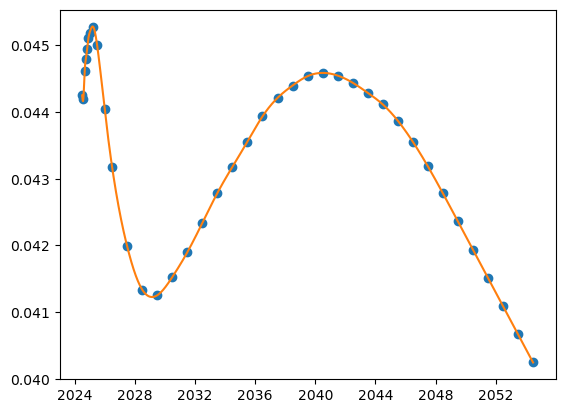

In [13]:
Yield.PlotZeroCurve()

Check the stripped yield has similar characteristics as the swap quotes.

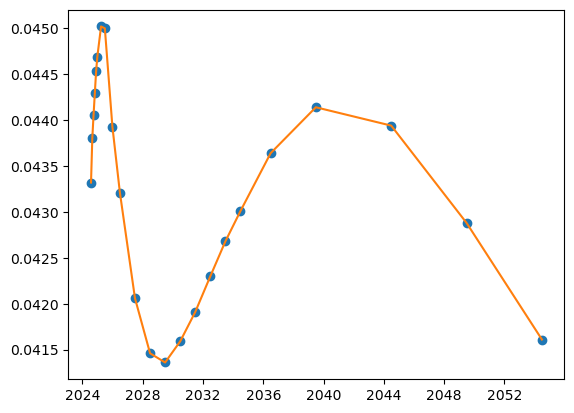

In [14]:
Yield.PlotSwapCurve()

## **4. Conclusion**

We success to build a smooth yield curve that is able to price all the inputs with 0 MtM.

It is known that this model has some limitations due to the simple assumption we made. However, it is just a matter to generalize the code to take different conventions, different coupon schedules and different curve nature (e.g. consider IR future for USD SOFR or EUR ESTR).

## Appendix

Formulas for continously compounding:
$$ r_{zero}(T_n) = -\frac{1}{\theta_{T_n}} ln(DF(T_n)) $$

$$ DF(T_n) = exp(- r_{zero}(T_n) * \theta_{T_n}) $$

$$ r_{zero}(T_n) = \frac{1}{\theta_{T_n}} ln\left(\dfrac{1+\theta_{1Y}*SwapRate}{1-\sum_{i=1}^{n-1}\theta_{1Y}*SwapRate*DF(T_i)}\right) $$

$$ r_{zero}(T_n) = \frac{1}{\theta_{T_n}} ln\left(\dfrac{1+\theta_{1Y}*SwapRate}{1-\sum_{i=1}^{n-1}\theta_{1Y}*SwapRate*exp(- r_{zero}(T_i) * \theta_{T_i})}\right) $$